# Ajuste polinómico

## Introducción

Consideremos el ejemplo siguiente donde tenemos datos del crecimiento de un tumor en ratones. 
Los datos son tomados (y mas información) se encuentran en: 
Modeling Cancer Growth with Differential Equations de Jue Wang, Department of Mathematics
Union College, Schenectady NY 12308 USA.

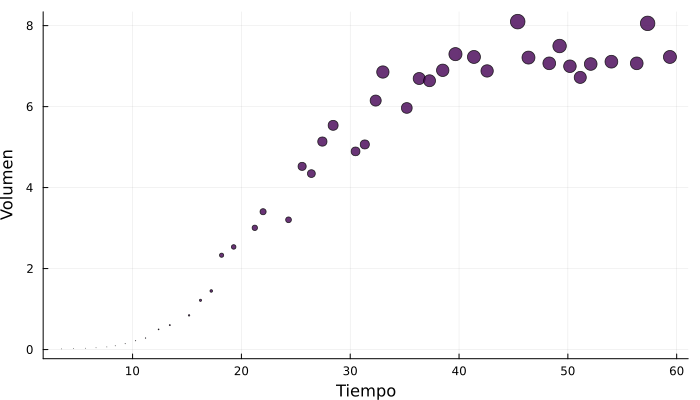

In [1]:
using Plots
using LinearAlgebra
using Distributions
using Statistics

#Datos
Datos = [3.46 0.0158; 4.58 0.0264; 5.67 0.0326; 6.64 0.0445; 7.63 0.0646; 
        8.41 0.0933; 9.32 0.1454; 10.27 0.2183; 11.19 0.2842; 12.39 0.4977; 
        13.42 0.6033; 15.19 0.8441; 16.24 1.2163; 17.23 1.447; 18.18 2.3298; 
        19.29 2.5342; 21.23 3.0064; 21.99 3.4044; 24.33 3.2046; 25.58 4.5241; 
        26.43 4.3459; 27.44 5.1374; 28.43 5.5376; 30.49 4.8946; 31.34 5.066; 
        32.34 6.1494; 33.00 6.8548; 35.20 5.9668; 36.34 6.6945; 37.29 6.6395; 
        38.50 6.8971; 39.67 7.2966; 41.37 7.2268; 42.58 6.8815; 45.39 8.0993; 
        46.38 7.2112; 48.29 7.0694; 49.24 7.4971; 50.19 6.9974; 51.14 6.7219; 
        52.10 7.0523; 54.00 7.1095; 56.33 7.0694; 57.33 8.0562; 59.38 7.2268]


tiempo = Datos[:, 1]
volumen = Datos[:,2]

#Gráfica
scatter(tiempo, volumen, markersize=volumen, color=:viridis, alpha=0.8, xlabel="Tiempo", ylabel="Volumen", 
    legend=false, grid=true, size=(700, 400))

## Función del algoritmo MHRW

In [2]:
function MHRW0(np,logenergia,soporte,puntoincial,sd=0.1,iteraciones=10000)
    #np es el número de parámetros a estimar
    #Se usa logenergia para controlar posibles errores numéricos 
    #log energía solo debe depender del vector de parámetros 
    #sd: desviación estándar del camino aleatorio
    samples = rand(np) 
    probabilities = [exp(logenergia(samples[:,end]))]

    Alpha = [0] # tasa de aceptación
    #sd: desviación estándar del camino aleatorio

    # MHRW
    for i in 1:iteraciones
        # Construcción de nuevas muestras con un camino aleatorio normal
        theta = samples[:,end]+ sd*randn(np)
        # Condición del soporte
        if soporte(theta) == false
            alpha = 0
            p2 = exp(logenergia(samples[:,end]))
        else
            p1 = exp(logenergia(theta))
            p2 = exp(logenergia(samples[:,end]))
            alpha = min(1, p1/p2)
        end 

        
        Alpha = hcat(Alpha,alpha)
        u = rand()
        #Selección de muestras
        if u < alpha
            samples = hcat(samples, theta)
            probabilities = hcat(probabilities,p1)
        else
            samples = hcat(samples, samples[:,end])
            probabilities = hcat(probabilities,p2)
        end
    end
    #Sistematic sampling
    initial_position = floor(100*rand())
    leap = 20
    samples_ss = samples[:, Int(initial_position):leap:end]
    probabilities_ss = probabilities[Int(initial_position):leap:end];

    #Estimations
    max_prob, position_ss = findmax(probabilities_ss)
    Max_likelihood = samples_ss[:, position_ss]
    Mean = mean(samples_ss, dims=2)
    return (Max_likelihood,max_prob,Mean,samples_ss,probabilities_ss,Alpha)
end


MHRW0 (generic function with 3 methods)

## Polinomio lineal

En el modelo lineal asumimos que:
$$
V(t) \approx k+mt,
$$
queremos estimar $m$ y $k$.


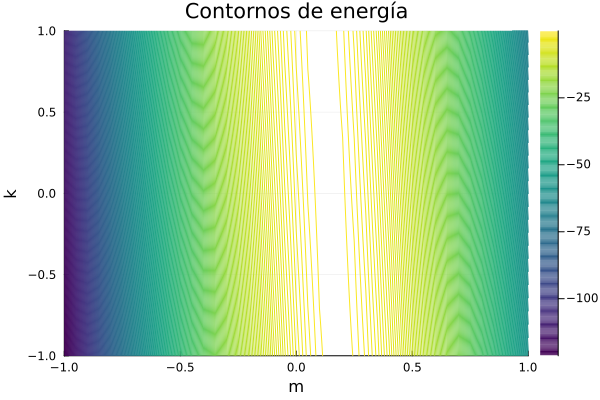

In [3]:
function sol_lineal(p)
    m = p[1]
    k = p[2]
    return m .* tiempo .+ k
end


#Energía
function energialinea(p) #log de la posterior
    m = p[1]
    k = p[2]

    mu = sol_lineal(p)
    #log_likelihood = sum(logpdf.(Normal.(mu, 10.0), volumen))
    log_likelihood = -0.5 * sum(volumen-mu)^2

    #log a priori
    log_priori = logpdf(Normal(0,10), m) + logpdf(Normal(0,10), k)

    return log_likelihood*(10^(-4)) + log_priori*(10^(-5)) #+ log(norm(p))*(10^(2))
end

function supportlin(pa)
    # soporte de los parametros ""
    rt = true
    rt &= (- 1.0 < pa[1] < 1.0)
    rt &= (- 1.0 < pa[2] < 1.0)
    return rt
end


g(x, y) = energialinea((x,y))

x_range = -1:0.05:1
y_range = -1:0.05:1

# Inicializar matrices para la malla
mesh_x = zeros(length(x_range), length(y_range))
mesh_y = zeros(length(x_range), length(y_range))
# Llenar las matrices de la malla con valores de x e y
for i in 1:length(x_range)
    for j in 1:length(y_range)
        mesh_x[i, j] = x_range[i]
        mesh_y[i, j] = y_range[j]
    end
end
# Evaluar la función en cada punto de la malla
z_values = g.(mesh_y, mesh_x)
# Crear el gráfico de contornos
contour(x_range, y_range, z_values, levels=300, color=:viridis, xlabel="m", ylabel="k", title="Contornos de energía")

In [4]:
Max_likelihood,max_prob,Mean,samples,probabilities,Alpha = MHRW0(2,energialinea,supportlin,rand(2),0.1,10000);
@show Max_likelihood
@show Mean ;

Max_likelihood = [0.1693447546875209, -0.7493594133406936]
Mean = [0.13871709784082942; -0.041542532459890376;;]


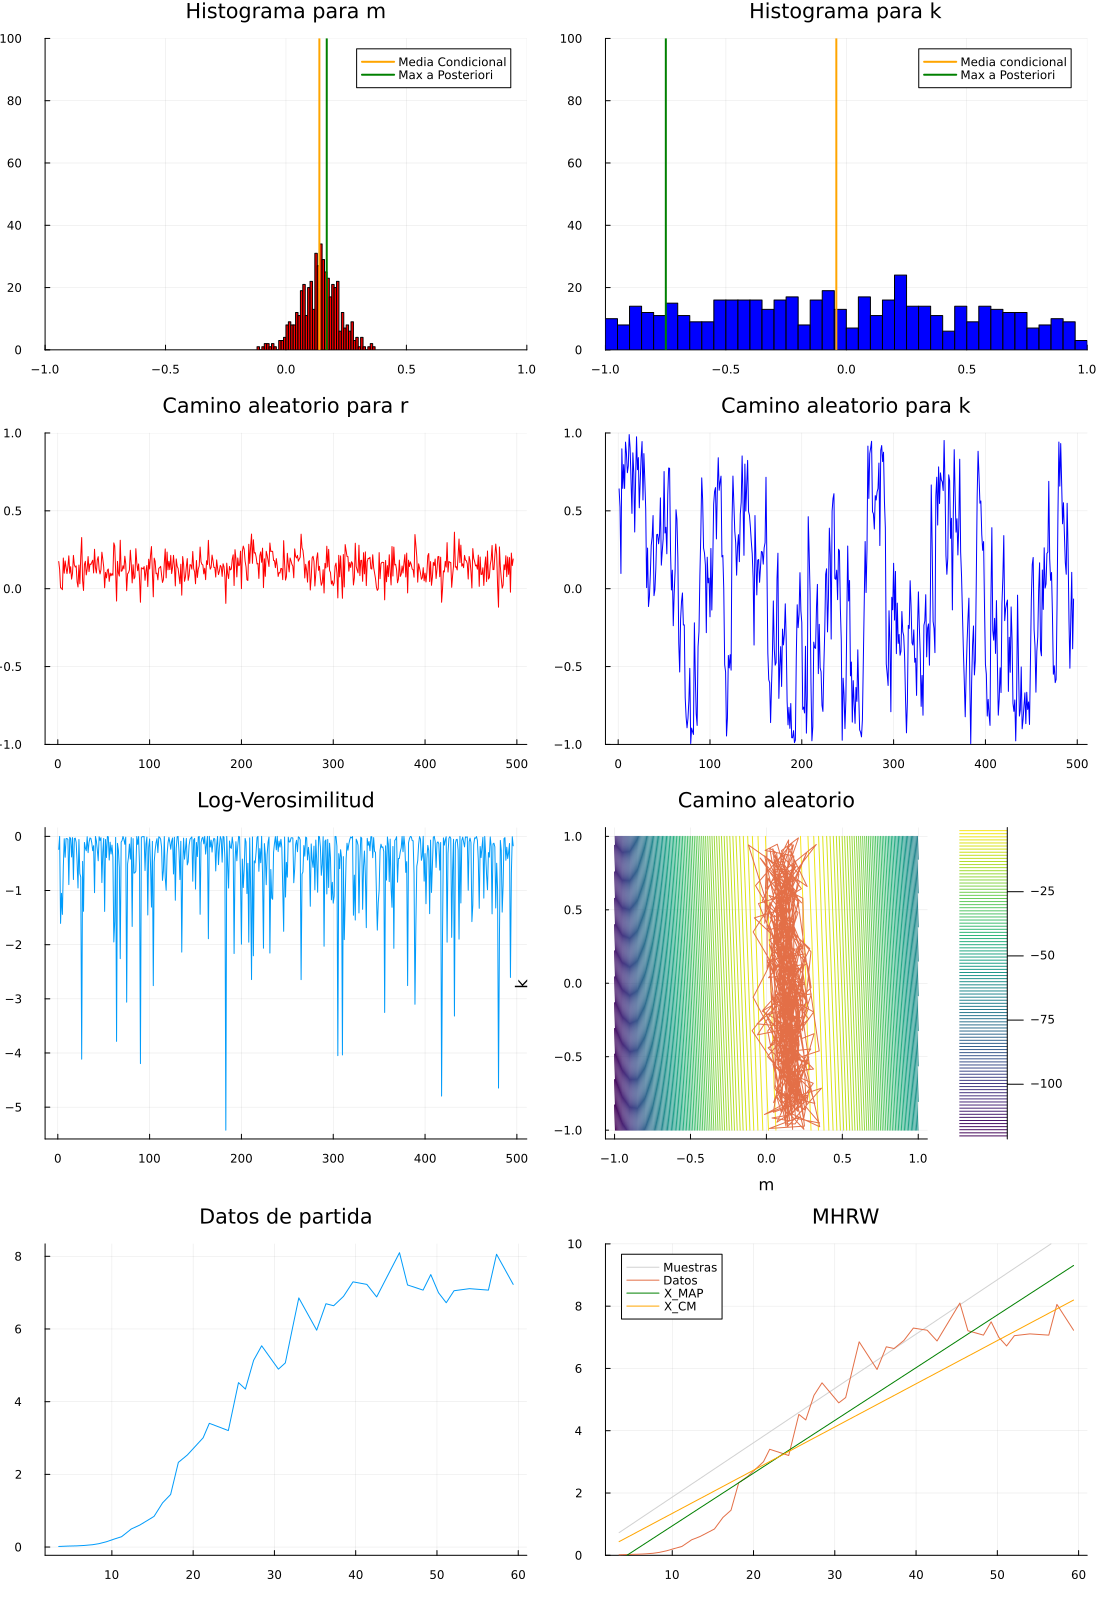

In [5]:
p1 = histogram(samples[1,:],bins=50,label=false,color="red",xlim=(-1,1),title="Histograma para m")
p1 = plot!([Mean[1], Mean[1]], [0,100],linewidth=2,color="orange", label="Media Condicional")
p1 = plot!([Max_likelihood[1], Max_likelihood[1]], [0,100],linewidth=2,color="green", label="Max a Posteriori")

p2 = histogram(samples[2,:],bins=50,label=false,color="blue",xlim=(-1,1),title="Histograma para k")
p2 = plot!([Mean[2], Mean[2]], [0,100],linewidth=2,color="orange", label="Media condicional")
p2 = plot!([Max_likelihood[2], Max_likelihood[2]], [0,100],linewidth=2,color="green", label="Max a Posteriori")

p3 = plot(samples[1,:],color="red",label = false,title="Camino aleatorio para r",ylim=(-1,1))

p4 = plot(samples[2,:],color="blue",label = false,title="Camino aleatorio para k",ylim=(-1,1))

p5 = plot(log.(probabilities), label=false , title="Log-Verosimilitud")

p6 = contour(x_range, y_range, z_values, levels=100, color=:viridis, xlabel="m", ylabel="k",title="Camino aleatorio")
p6 = plot!(samples[1,:],samples[2,:],label=false)

p7 = plot(tiempo, volumen ,label=false, title = "Datos de partida")

p8 = plot(tiempo,sol_lineal(samples[end-1,:]),
    color="gray82",title="MHRW",label="Muestras",z=1,size=(1000, 600),ylim=(0,10))
#for j=1:10:(size(samples)[2]-1)
 #  p8 = plot!(tiempo,sol_lineal((samples[:,j][1],samples[:,j][2])),color="gray82",label=false,z=1)
#end
p8 = plot!(tiempo, volumen,label="Datos")
p8 = plot!(tiempo, sol_lineal((Max_likelihood[1],Max_likelihood[2])),color="green",label="X_MAP")
p8 = plot!(tiempo, sol_lineal((Mean[1],Mean[2])),color="orange",label="X_CM")


plot(p1,p2,p3,p4,p5,p6,p7,p8, layout=(4,2),size=(1100,1600))

## Ecuación diferencial con condición inicial

Considere el modelo de ecuaciones diferenciales, 
$$
V'= aV^\frac{2}{3}-bV,
$$
con $V_0=V(0)$ dado. La variable $V$ representa o aproxima el volumen del tumor en el tiempo $t$.

In [3]:
function MetEuler(f, p, y0, t0, tn, h)
    # f: función que define la EDO dy/dt = f(t, y; p)
    # y0: condición inicial
    # t0: tiempo inicial
    # tn: tiempo final
    # h: tamaño del paso
    # p: parámetros de la función f

    # Número de pasos
    n_steps = Int((tn - t0) / h)
    
    t_values = zeros(n_steps + 1)
    y_values = zeros(n_steps + 1)

    # Condiciones iniciales
    t_values[1] = t0
    y_values[1] = y0

    # Método de Euler
    for i in 1:n_steps
        t_values[i + 1] = t_values[i] + h
        y_values[i + 1] = y_values[i] + h * f(t_values[i], y_values[i],p)
    end

    return t_values, y_values
end

function MetEulerT(f, p, y0, t)
    # f: función que define la EDO dy/dt = f(t, y; p)
    # y0: condición inicial
    # t: arreglo que para el tiempo
    # p: parámetros de la función f

    # Número de pasos
    n_steps = size(t)[1]-1
    
    t_values = t
    y_values = zeros(n_steps + 1)

    # Condiciones iniciales
    y_values[1] = y0

    # Método de Euler
    for i in 1:n_steps
        h = t[i+1]-t[i]
        y_values[i + 1] = y_values[i] + h * f(t_values[i], y_values[i],p)
    end

    return y_values
end

#Lado derecho de la ecuación diferencial
function rhs_ED(t,x,p)
    a = p[1]
    b = p[2]
    return a*(abs(x)^(2/3))-b*x
end
#Punto inicial del volumen
V0=0.0158
#Solución numérica
function sol_num_ED(p)
    a = p[1]
    b = p[2]
    return MetEulerT(rhs_ED, [a, b], V0, tiempo)
end


sol_num_ED (generic function with 1 method)

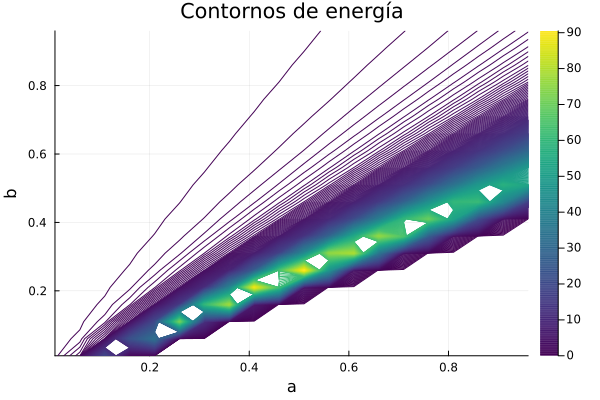

In [10]:
#Energía
function energiaEDO(p) #log de la posterior
    a = p[1]
    b = p[2]
    #logverosimilitud gaussiana
    log_likelihood = -0.5 .* sum((volumen - sol_num_ED(p)).^2)
    
    #log a priori
    log_priori = logpdf(Normal(0.5,1), a) + logpdf(Normal(0.5,1), b)

    return  log_likelihood*(10^(-2)) + log_priori*(10^(-2)) + log(100)
end


function support(pa)
    # soporte de los parametros ""
    rt = true
    rt &= (0.0 < pa[1] < 1.0)
    rt &= (0.0 < pa[2] < 1.0)
    return rt
end



f(x, y) = energiaEDO((x,y))

x_range = 0.01:0.05:1
y_range = 0.01:0.05:1

# Inicializar matrices para la malla
mesh_x = zeros(length(x_range), length(y_range))
mesh_y = zeros(length(x_range), length(y_range))
# Llenar las matrices de la malla con valores de x e y
for i in 1:length(x_range)
    for j in 1:length(y_range)
        mesh_x[i, j] = x_range[i]
        mesh_y[i, j] = y_range[j]
    end
end
# Evaluar la función en cada punto de la malla
z_values = f.(mesh_y, mesh_x)
# Crear el gráfico de contornos
contour(x_range, y_range, exp.(z_values), levels=500, color=:viridis, xlabel="a", ylabel="b", title="Contornos de energía")


In [11]:
Max_likelihood,max_prob,Mean,samples,probabilities,Alpha = MHRW0(2,energiaEDO,support,rand(2),0.01,20000);
@show Max_likelihood
@show Mean ;

Max_likelihood = [0.445691086924381, 0.22199621265797317]
Mean = [0.6362246679342777; 0.37077764478564584;;]


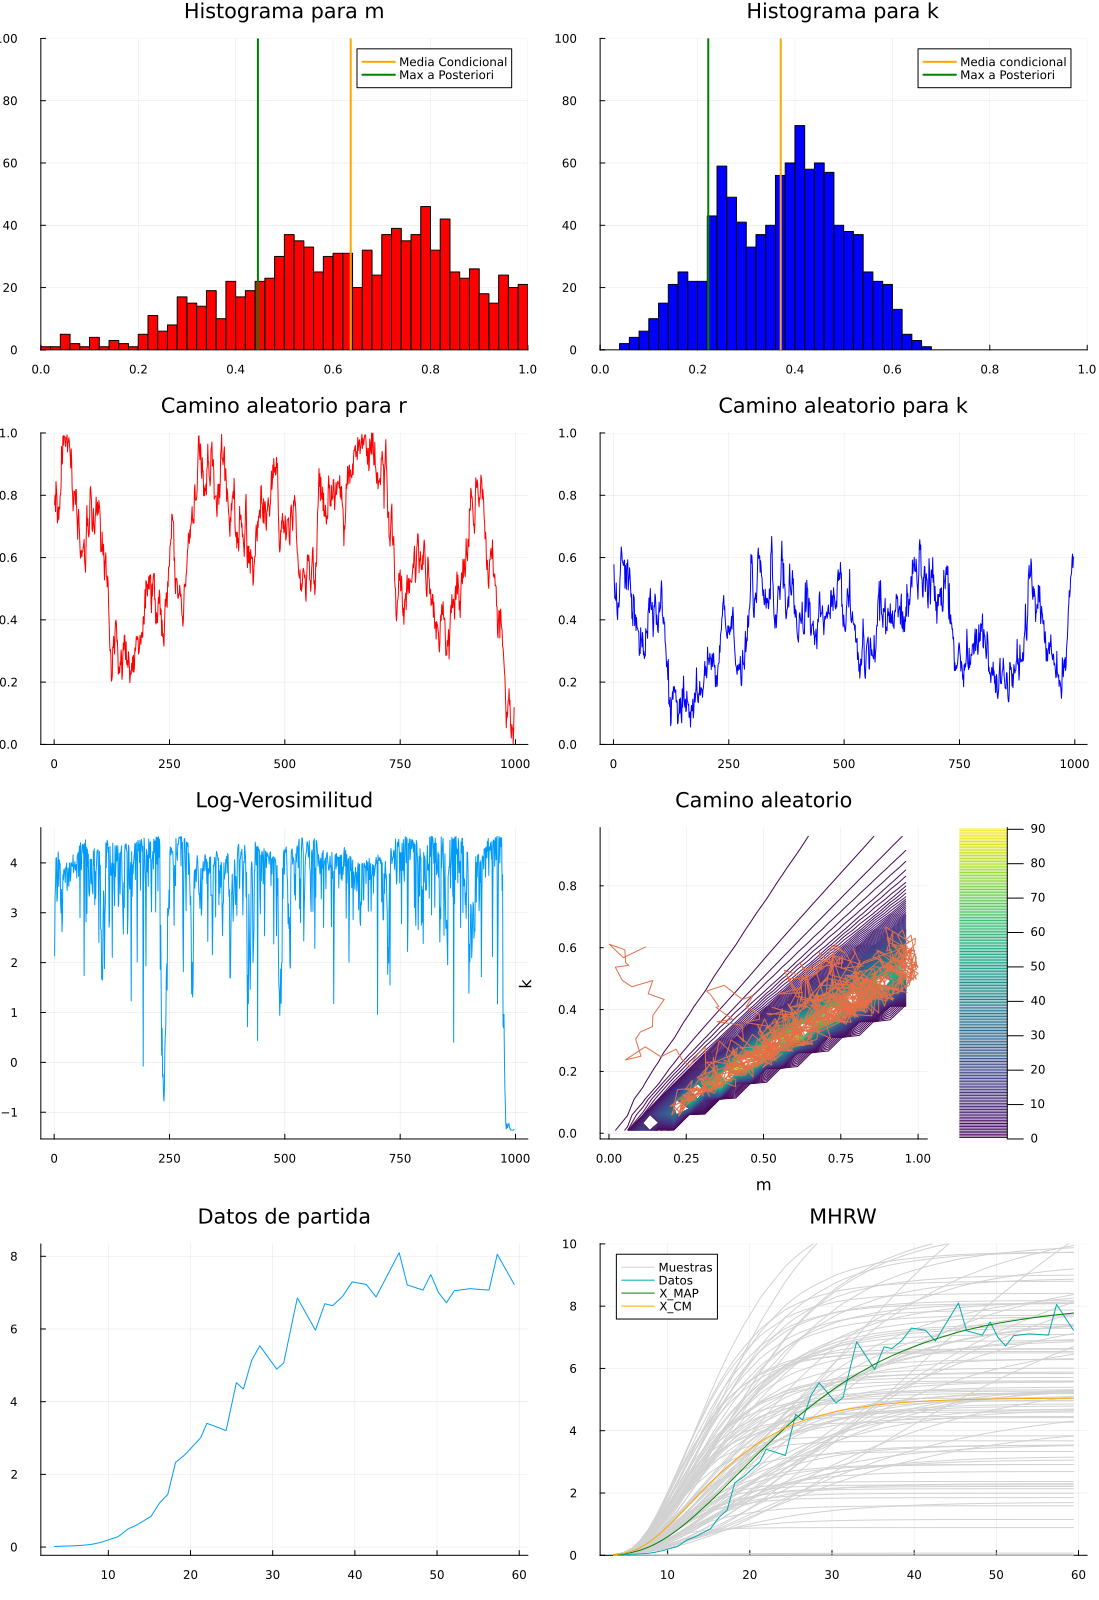

In [12]:
p1 = histogram(samples[1,:],bins=50,label=false,color="red",xlim=(0,1),title="Histograma para m")
p1 = plot!([Mean[1], Mean[1]], [0,100],linewidth=2,color="orange", label="Media Condicional")
p1 = plot!([Max_likelihood[1], Max_likelihood[1]], [0,100],linewidth=2,color="green", label="Max a Posteriori")

p2 = histogram(samples[2,:],bins=50,label=false,color="blue",xlim=(0,1),title="Histograma para k")
p2 = plot!([Mean[2], Mean[2]], [0,100],linewidth=2,color="orange", label="Media condicional")
p2 = plot!([Max_likelihood[2], Max_likelihood[2]], [0,100],linewidth=2,color="green", label="Max a Posteriori")

p3 = plot(samples[1,:],color="red",label = false,title="Camino aleatorio para r",ylim=(0,1))

p4 = plot(samples[2,:],color="blue",label = false,title="Camino aleatorio para k",ylim=(0,1))

p5 = plot(log.(probabilities), label=false , title="Log-Verosimilitud")

p6 = contour(x_range, y_range, exp.(z_values), levels=200, color=:viridis, xlabel="m", ylabel="k",title="Camino aleatorio")
p6 = plot!(samples[1,:],samples[2,:],label=false)

p7 = plot(tiempo, volumen ,label=false, title = "Datos de partida")

p8 = plot(tiempo,sol_num_ED(samples[end-1,:]),
    color="gray82",title="MHRW",label="Muestras",z=1,size=(1000, 600),ylim= (0,10))
for j=1:10:(size(samples)[2]-1)
   p8 = plot!(tiempo,sol_num_ED((samples[:,j][1],samples[:,j][2])),color="gray82",label=false,z=1)
end
p8 = plot!(tiempo, volumen,label="Datos")
p8 = plot!(tiempo, sol_num_ED((Max_likelihood[1],Max_likelihood[2])),color="green",label="X_MAP")
p8 = plot!(tiempo, sol_num_ED((Mean[1],Mean[2])),color="orange",label="X_CM")


plot(p1,p2,p3,p4,p5,p6,p7,p8, layout=(4,2),size=(1100,1600))